In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import librosa
from shutil import copyfile
import matplotlib.style as ms
from tqdm import tqdm
import pickle
import random

import IPython.display
import librosa.display
from joblib import delayed
import os
import math

ms.use('seaborn-muted')
%matplotlib inline

In [2]:
#   !wget nipg12.inf.elte.hu/~fodor@nipg.lab/db/IEMOCAP.zip
#   !unzip IEMOCAP.zip  -d IEMOCAP

# Extract labels from the evaluation files

extract labels from transriptions and compile other required data into a csv.

Test for one file first

In [2]:
import re

# first test with one file
file_path = './IEMOCAP/nas/database/IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Ses01F_impro01.txt'

In [3]:
useful_regex = re.compile(r'\[.+\]\n', re.IGNORECASE)

In [4]:
with open(file_path) as f:
    file_content = f.read()
    
info_lines = re.findall(useful_regex, file_content)

In [5]:
for l in info_lines[1:20]:
    print(l.strip().split('\t'))

['[6.2901 - 8.2357]', 'Ses01F_impro01_F000', 'neu', '[2.5000, 2.5000, 2.5000]']
['[10.0100 - 11.3925]', 'Ses01F_impro01_F001', 'neu', '[2.5000, 2.5000, 2.5000]']
['[14.8872 - 18.0175]', 'Ses01F_impro01_F002', 'neu', '[2.5000, 2.5000, 2.5000]']
['[19.2900 - 20.7875]', 'Ses01F_impro01_F003', 'xxx', '[2.5000, 3.0000, 3.0000]']
['[21.3257 - 24.7400]', 'Ses01F_impro01_F004', 'xxx', '[2.5000, 3.0000, 2.5000]']
['[27.4600 - 31.4900]', 'Ses01F_impro01_F005', 'neu', '[2.5000, 3.5000, 2.0000]']
['[38.9650 - 43.5900]', 'Ses01F_impro01_F006', 'fru', '[2.0000, 3.5000, 3.5000]']
['[46.5800 - 52.1900]', 'Ses01F_impro01_F007', 'fru', '[2.5000, 3.5000, 3.5000]']
['[56.1600 - 58.8225]', 'Ses01F_impro01_F008', 'fru', '[2.0000, 3.5000, 3.5000]']
['[61.8700 - 65.9700]', 'Ses01F_impro01_F009', 'fru', '[2.0000, 3.5000, 3.0000]']
['[66.4200 - 69.3400]', 'Ses01F_impro01_F010', 'xxx', '[1.5000, 3.5000, 3.5000]']
['[72.4500 - 82.2600]', 'Ses01F_impro01_F011', 'fru', '[2.0000, 3.5000, 3.5000]']
['[85.2700 - 88.02

### Compile all the information in a single file

In [6]:
import re


info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

start_times, end_times, wav_file_names, emotions, vals, acts, doms = [], [], [], [], [], [], []

for sess in range(1, 6):
    emo_evaluation_dir = './IEMOCAP/nas/database/IEMOCAP_full_release/Session{}/dialog/EmoEvaluation/'.format(sess)
    evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
    for file in evaluation_files:
        with open(emo_evaluation_dir + file) as f:
            content = f.read()
        info_lines = re.findall(info_line, content)
        for line in info_lines[1:]:  # the first line is a header
            start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
            start_time, end_time = start_end_time[1:-1].split('-')
            val, act, dom = val_act_dom[1:-1].split(',')
            val, act, dom = float(val), float(act), float(dom)
            start_time, end_time = float(start_time), float(end_time)
            start_times.append(start_time)
            end_times.append(end_time)
            wav_file_names.append(wav_file_name)
            emotions.append(emotion)
            vals.append(val)
            acts.append(act)
            doms.append(dom)

In [7]:

df_iemocap = pd.DataFrame(columns=['start_time', 'end_time', 'wav_file', 'emotion', 'val', 'act', 'dom'])

df_iemocap['start_time'] = start_times
df_iemocap['end_time'] = end_times
df_iemocap['wav_file'] = wav_file_names
df_iemocap['emotion'] = emotions
df_iemocap['val'] = vals
df_iemocap['act'] = acts
df_iemocap['dom'] = doms

df_iemocap.head()

,start_time,end_time,wav_file,emotion,val,act,dom
0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,19.2900,20.7875,Ses01F_impro01_F003,xxx,2.5,3.0,3.0
4,21.3257,24.7400,Ses01F_impro01_F004,xxx,2.5,3.0,2.5


In [8]:
df_iemocap["emotion"].value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: emotion, dtype: int64

In [9]:
df_iemocap.shape

(10039, 7)

In [10]:
df_iemocap.to_csv('data/pre-processed_data/df_iemocap_5.csv', index=False)

# Build Audio Vectors

build vectors from the original wav files and save into a pickle file

In [11]:
import soundfile as sf
import matplotlib.pyplot as plt



In [13]:
labels_df = pd.read_csv('data/pre-processed_data/df_iemocap_5.csv')
iemocap_dir = 'IEMOCAP/nas/database/IEMOCAP_full_release/'

In [14]:
sr = 44100
audio_vectors = {}
for sess in range(1, 6): 
    wav_file_path = '{}Session{}/dialog/wav/'.format(iemocap_dir, sess)
    orig_wav_files = os.listdir(wav_file_path)
    for orig_wav_file in tqdm(orig_wav_files):
        try:
            orig_wav_vector, _sr = librosa.load(wav_file_path + orig_wav_file, sr=sr)
            orig_wav_file, file_format = orig_wav_file.split('.')
            for index, row in labels_df[labels_df['wav_file'].str.contains(orig_wav_file)].iterrows():
                start_time, end_time, truncated_wav_file_name, emotion, val, act, dom = row['start_time'], row['end_time'], row['wav_file'], row['emotion'], row['val'], row['act'], row['dom']
                start_frame = math.floor(start_time * sr)
                end_frame = math.floor(end_time * sr)
                truncated_wav_vector = orig_wav_vector[start_frame:end_frame + 1]
                audio_vectors[truncated_wav_file_name] = truncated_wav_vector
        except:
            print('An exception occured for {}'.format(orig_wav_file))
    with open('data/pre-processed_data/audio_vectors_{}.pkl'.format(sess), 'wb') as f:
        pickle.dump(audio_vectors, f)

100%|██████████| 31/31 [05:38<00:00, 10.93s/it]


# Extract audio features

extract 8-dimensional audio feature vectors for the audio vectors

In [15]:
import soundfile as sf
import numpy as np

ms.use('seaborn-muted')
%matplotlib inline

In [16]:
data_dir = 'data/pre-processed_data/'
labels_df_path = '{}df_iemocap_5.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_5.pkl'.format(data_dir)

In [17]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [18]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

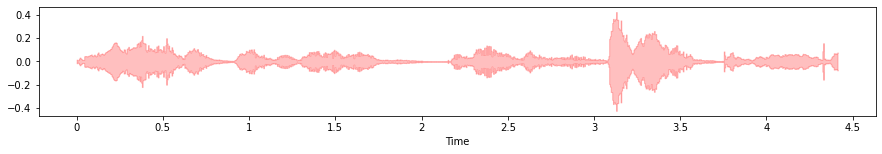

In [19]:
plt.figure(figsize=(15,2))
librosa.display.waveshow(y, sr=sr, max_points=1000, alpha=0.25, color='r')

In [20]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.02089
Signal std dev = 0.03441


RMSE mean = 0.02626
RMSE std dev = 0.02216


C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/295443941.py:1: FutureWarning: Pass y=[0.00469288 0.00477645 0.00431077 ... 0.04980146 0.05010769 0.04929842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]


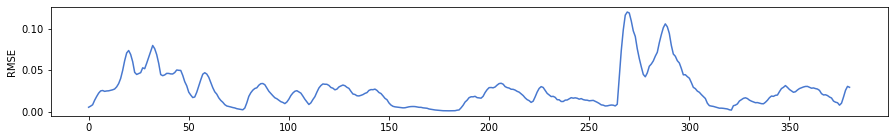

In [21]:
rmse = librosa.feature.rms(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [23]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.2230971128608924


In [24]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-3.354711e-06

In [25]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

230.81966326437617

In [13]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

2.5900681564265073

In [26]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [27]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed_data/'
labels_path = '{}df_iemocap_5.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [28]:
labels_df = pd.read_csv(labels_path)

for sess in (range(1, 6)):
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std

                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

df_features.to_csv('data/pre-processed_data/audio_features.csv', index=False)

0it [00:00, ?it/s]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[-0.00234204 -0.00344994 -0.00417934 ... -0.00226033 -0.0016417
 -0.00130466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
1it [00:00,  1.29it/s]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[ 0.00150332  0.00106107  0.00104068 ... -0.00188802 -0.00190317
 -0.00200696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
2it [00:01,  1.57it/s]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[-2.7102709e-03 -2.7402462e-03 -2.7047216e-03 ...  6.7513098e-04
 -3.3417011e-05 -8.6472672e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.

Some exception occured


772it [24:57,  1.27s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[ 0.00133878  0.0017485   0.00222618 ... -0.00085441 -0.00103258
 -0.00087345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
773it [24:57,  1.12s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[ 4.9578506e-03  4.0603816e-03  3.1682802e-03 ...  4.3449880e-05
 -6.5254821e-03 -1.4703479e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
774it [25:00,  1.60s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[-0.00345578 -0.003718   -0.00403574 ... -0.00104535 -0.00058924
 -0.00029669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature

Some exception occured


1224it [1:04:53,  1.71s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[0.00126052 0.0011745  0.00102278 ... 0.0008005  0.00088207 0.00093901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
1225it [1:04:54,  1.66s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[-1.5275687e-03 -1.3649539e-03 -1.2235299e-03 ... -3.2526432e-04
 -5.2561889e-05  2.4560816e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.feature.rms(y + 0.0001)[0]
1226it [1:04:55,  1.52s/it]C:\Users\chaim\AppData\Local\Temp/ipykernel_18704/1748365198.py:16: FutureWarning: Pass y=[ 0.00026602  0.00027769  0.0002824  ... -0.00073702 -0.00068054
 -0.0006771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rmse = librosa.featu

# Build Speech data files

preprocess and prepare audio data for experiments

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [31]:
df = pd.read_csv('data/pre-processed_data/audio_features.csv')
df = df[df['label'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
print(df.shape)
display(df.head())

# change 7 to 2
df['label'] = df['label'].map({0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 4, 7: 5})
df.head()

(7527, 10)


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_impro01_F000,7,0.004029,0.007451,0.005045,0.005466,0.125000,-0.007787,0.043667,0.165918
1,Ses01F_impro01_F001,7,0.004209,0.009823,0.005309,0.008218,0.491667,-0.006072,0.083406,0.160758
2,Ses01F_impro01_F002,7,0.003928,0.007829,0.004941,0.006064,0.385185,-0.010218,0.049978,0.112936
5,Ses01F_impro01_F005,7,0.030085,0.054550,0.037255,0.039751,0.428161,-0.005372,2.280359,7.328889
6,Ses01F_impro01_F006,4,0.046330,0.074601,0.056799,0.048212,0.255639,-0.009276,3.977543,21.287291


,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_impro01_F000,5,0.004029,0.007451,0.005045,0.005466,0.125000,-0.007787,0.043667,0.165918
1,Ses01F_impro01_F001,5,0.004209,0.009823,0.005309,0.008218,0.491667,-0.006072,0.083406,0.160758
2,Ses01F_impro01_F002,5,0.003928,0.007829,0.004941,0.006064,0.385185,-0.010218,0.049978,0.112936
5,Ses01F_impro01_F005,5,0.030085,0.054550,0.037255,0.039751,0.428161,-0.005372,2.280359,7.328889
6,Ses01F_impro01_F006,2,0.046330,0.074601,0.056799,0.048212,0.255639,-0.009276,3.977543,21.287291


In [32]:
df.to_csv('data/no_sample_df.csv')

# oversample fear
fear_df = df[df['label']==3]
for i in range(30):
    df = df.append(fear_df)

sur_df = df[df['label']==4]
for i in range(10):
    df = df.append(sur_df)
    
df.to_csv('data/modified_df.csv')

In [37]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'neu': 3,}

# emotion_dict = {'ang': 0,
#                 'hap': 1,
#                 'exc': 2,
#                 'sad': 3,
#                 'fru': 4,
#                 'fea': 5,
#                 'sur': 6,
#                 'neu': 7,
#                 'xxx': 8,
#                 'oth': 8}

scalar = MinMaxScaler()
df[df.columns[2:]] = scalar.fit_transform(df[df.columns[2:]])
df.head()

,wav_file,label,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,Ses01F_impro01_F000,5,0.012103,0.017845,0.012492,0.029385,0.162594,0.171332,0.000525,0.000584
1,Ses01F_impro01_F001,5,0.012736,0.024158,0.013257,0.044487,0.639536,0.171667,0.001006,0.000566
2,Ses01F_impro01_F002,5,0.011748,0.018851,0.012190,0.032670,0.501030,0.170858,0.000601,0.000397
5,Ses01F_impro01_F005,5,0.103591,0.143190,0.105661,0.217510,0.556931,0.171803,0.027590,0.025904
6,Ses01F_impro01_F006,2,0.160630,0.196552,0.162190,0.263937,0.332523,0.171041,0.048128,0.075244


In [35]:
x_train, x_test = train_test_split(df, test_size=0.20)

x_train.to_csv('data/s2e/audio_train.csv', index=False)
x_test.to_csv('data/s2e/audio_test.csv', index=False)

print(x_train.shape, x_test.shape)

(7837, 10) (1960, 10)
